# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [2]:
# TODO: load your data
# df = pd.read_csv('../data/Nat_Gas.csv', parse_dates=['Dates'], index_col='Dates')
# df

## Option B: Synthetic Generator (Use if you don't have data ready)

In [3]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


## Feature Engineering

In [4]:
# TODO: create at least two features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# Add your own:
df['roll_mean_20'] = df['ret'].rolling(20).mean().shift(1)
df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)
df['zscore'] = (df['ret'] - df['roll_mean_20'])/df['roll_vol_20']
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,roll_mean_20,roll_vol_20,zscore,y_next_ret,y_up
2021-01-29,100.198878,0.016949,0.016807,-0.014854,-0.003707,-0.001574,0.007370,2.513413,0.001845,1
2021-02-01,100.383751,0.001845,0.001843,0.016949,0.002509,-0.000727,0.008455,0.304166,-0.003565,0
2021-02-02,100.025880,-0.003565,-0.003571,0.001845,0.001706,-0.000417,0.008429,-0.373512,0.020804,1
2021-02-03,102.106835,0.020804,0.020591,-0.003565,0.000685,-0.000627,0.008453,2.535190,-0.000154,0
2021-02-04,102.091126,-0.000154,-0.000154,0.020804,0.004236,0.000194,0.009675,-0.035999,-0.014106,0


## Split

In [5]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5', 'roll_vol_20','zscore']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model (Choose one track below)

In [6]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
rmse = mean_squared_error(y_te_reg, pred)
print('RMSE:', rmse)

RMSE: 0.00021032348425647614


              precision    recall  f1-score   support

           0       0.57      0.79      0.66        53
           1       0.50      0.26      0.34        43

    accuracy                           0.55        96
   macro avg       0.53      0.52      0.50        96
weighted avg       0.54      0.55      0.52        96



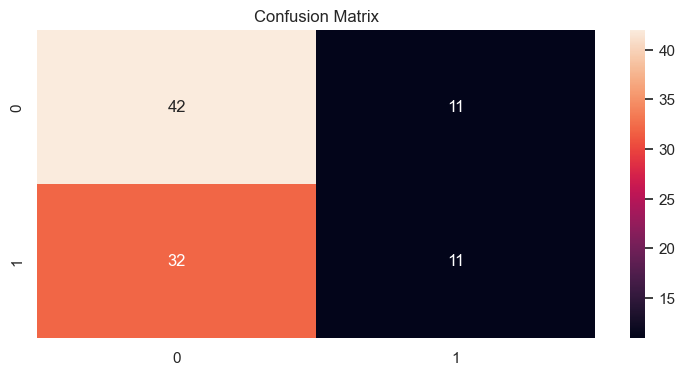

In [7]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

## Interpretation
- What worked?
  - The fact that we shifted features and split by time can avoid data leakage.
  - The pipeline for scaling and modeling can keep train/test preprocessing consistent.
- Where might assumptions fail?
  - homoscedasticity: volatility jumps violate constant-variance assumptions of linear models
  - Lags and rolling features assume that past patterns can predict the future. However, when regime shifts occur, the assumptions may fail.
- How would you extend the features or the model?
  - consider `lag_1` × `roll_vol_20` (momentum works differently in high vol)
  - try to winsorize extreme values as a sensitivity check